- WGAN used weight clipping (clamp_(-0.01, 0.01)) to keep the critic Lipschitz continuous (a math property needed for WGAN).
- But clipping made the critic too weak, limiting its learning capacity.
- WGAN-GP removes weight clipping and instead adds a gradient penalty to enforce the Lipschitz constraint more effectively.

In [2]:
!pip3 install torchinfo

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
from tqdm import tqdm

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"
lr=1e-4
batch_size=64
img_size=64
z_dim=100
num_epochs=5
features_disc=5
features_gen=5
critic_iter=5
lambda_gp=10

In [5]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super().__init__()

    self.main=nn.Sequential(
        nn.ConvTranspose2d(in_channels=noise_dim,out_channels=1024,kernel_size=4,stride=2,padding=0,bias=False), #(N,z_dim,1,1) -> N,1024,4,4)
        nn.BatchNorm2d(1024),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False), # (N,1024,4,4) -> (N,512,8,8)
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),#(N,512,8,8) -> (N,256,16,16)
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False), #(N,256,16,16) -> (N,128,32,32)
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=4,stride=2,padding=1,bias=False), #(N,128,32,32) ->  (N, 3, 64, 64)
        nn.Tanh()

    )

  def forward(self,z):
    return self.main(z)

generator_test=Generator(noise_dim=100 )

# Generate random noise (N, z_dim, 1, 1)
noise = torch.randn(16, 100, 1, 1)
with torch.no_grad():
    fake_images = generator_test(noise)
print(fake_images.shape) #torch.Size([16, 3, 64, 64]) correct shape
summary(model=generator_test,
        input_size=(128, 100, 1, 1),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


torch.Size([16, 3, 64, 64])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [128, 100, 1, 1]     [128, 3, 64, 64]     --                   True
├─Sequential (main)                      [128, 100, 1, 1]     [128, 3, 64, 64]     --                   True
│    └─ConvTranspose2d (0)               [128, 100, 1, 1]     [128, 1024, 4, 4]    1,638,400            True
│    └─BatchNorm2d (1)                   [128, 1024, 4, 4]    [128, 1024, 4, 4]    2,048                True
│    └─ReLU (2)                          [128, 1024, 4, 4]    [128, 1024, 4, 4]    --                   --
│    └─ConvTranspose2d (3)               [128, 1024, 4, 4]    [128, 512, 8, 8]     8,388,608            True
│    └─BatchNorm2d (4)                   [128, 512, 8, 8]     [128, 512, 8, 8]     1,024                True
│    └─ReLU (5)                          [128, 512, 8, 8]     [128, 512, 8, 8]     --                   --
│    └─ConvTranspo

In [6]:
class critic(nn.Module):
  def __init__(self):
    super().__init__()
    self.main=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False), # (N,3,64,64) -> (N,64,32,32)
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False), #(N,64,32,32) -> (N,128,16,16)
        nn.InstanceNorm2d(128,affine=True),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False), #(N,128,16,16) -> (N,256,8,8)
        nn.InstanceNorm2d(256, affine=True),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.InstanceNorm2d(512,affine=True),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=2,padding=0,bias=False)


    )

  def forward(self,img):
    return self.main(img) # (N,1,1,1)

disc_test=critic()
test_input = torch.randn(16, 3, 64, 64)
with torch.no_grad():
    test_output = disc_test(test_input)
print(test_output.shape)
summary(model=disc_test,
        input_size=(16,3,64,64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

torch.Size([16, 1, 1, 1])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
critic (critic)                          [16, 3, 64, 64]      [16, 1, 1, 1]        --                   True
├─Sequential (main)                      [16, 3, 64, 64]      [16, 1, 1, 1]        --                   True
│    └─Conv2d (0)                        [16, 3, 64, 64]      [16, 64, 32, 32]     3,072                True
│    └─LeakyReLU (1)                     [16, 64, 32, 32]     [16, 64, 32, 32]     --                   --
│    └─Conv2d (2)                        [16, 64, 32, 32]     [16, 128, 16, 16]    131,072              True
│    └─InstanceNorm2d (3)                [16, 128, 16, 16]    [16, 128, 16, 16]    256                  True
│    └─LeakyReLU (4)                     [16, 128, 16, 16]    [16, 128, 16, 16]    --                   --
│    └─Conv2d (5)                        [16, 128, 16, 16]    [16, 256, 8, 8]      524,288              True
│    └─InstanceNor

In [7]:
def initialize_weights(model):

  for m in model.parameters():
    if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      m.init.normal_(m.weight.data,0.0,0.02)

In [8]:

# Install gdown if not installed
!pip install gdown

# Download the file
file_id = "1wosz2L1jboWuGp5_7-I9cSV0iUbIQhQY"
gdown_url = f"https://drive.google.com/uc?id={file_id}"
!gdown {gdown_url}

# Optional: Unzip the file if it's a zip
!unzip -q '*.zip' -d ./dataset

Downloading...
From (original): https://drive.google.com/uc?id=1wosz2L1jboWuGp5_7-I9cSV0iUbIQhQY
From (redirected): https://drive.google.com/uc?id=1wosz2L1jboWuGp5_7-I9cSV0iUbIQhQY&confirm=t&uuid=15db007e-9330-4a8a-bcc9-9c2eec74b560
To: /content/Copy of img_align_celeba.zip
100% 1.44G/1.44G [00:15<00:00, 93.0MB/s]


In [9]:


transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # transform the images as done in the paper
])
data=datasets.ImageFolder(root='dataset',transform=transform)
dataloader=DataLoader(data,batch_size=128,shuffle=True)
next(iter(dataloader))

[tensor([[[[-0.9216, -0.9216, -0.9216,  ..., -0.9137, -0.9137, -0.9059],
           [-0.9216, -0.9216, -0.9216,  ..., -0.9137, -0.9137, -0.9137],
           [-0.9216, -0.9216, -0.9216,  ..., -0.9216, -0.9216, -0.9216],
           ...,
           [-0.6471, -0.7647, -0.8510,  ...,  0.7725,  0.8039,  0.8118],
           [-0.4431, -0.4902, -0.5373,  ...,  0.7882,  0.8196,  0.8510],
           [-0.4039, -0.4667, -0.4980,  ...,  0.7961,  0.8275,  0.8431]],
 
          [[-0.9216, -0.9216, -0.9216,  ..., -0.9137, -0.9137, -0.9059],
           [-0.9216, -0.9216, -0.9216,  ..., -0.9137, -0.9137, -0.9137],
           [-0.9216, -0.9216, -0.9216,  ..., -0.9216, -0.9216, -0.9216],
           ...,
           [-0.6863, -0.7961, -0.8745,  ...,  0.3882,  0.4039,  0.3961],
           [-0.5294, -0.5765, -0.6157,  ...,  0.4039,  0.4196,  0.4353],
           [-0.5373, -0.5922, -0.6078,  ...,  0.4118,  0.4275,  0.4353]],
 
          [[-0.9216, -0.9216, -0.9216,  ..., -0.9137, -0.9137, -0.9059],
           [-

In [10]:
def gradient_penalty(critic, real, fake,lambda_gp, device="cpu"):

  batch_size,N,H,W=real.shape
  epsilon= torch.rand(batch_size,1,1,1,device=real.device) #for element wise multiplication
  interpolated_images=real*epsilon+fake*(1-epsilon)
  interpolated_images.requires_grad_(True)
  critic_output=critic(interpolated_images)

  #computing gradient
  gradient=torch.autograd.grad( #computes gradient of the outputs wrt the inputs
      inputs=interpolated_images,
      outputs=critic_output,
      grad_outputs=torch.ones_like(critic_output),
      create_graph=True, #allows for further differentiation if needed
      retain_graph=True # for backward diff
  )[0]

  gradient_norm=gradient.view(gradient.size(0),-1).norm(2,dim=1)
  gradient_penalty=torch.mean((gradient_norm-1)**2)
  return lambda_gp*gradient_penalty

In [11]:
batch_size=64
noise_dim=100
lr_=5e-7
num_epochs=5
device='cuda' if torch.cuda.is_available() else "cpu"
fixed_noise = torch.randn((batch_size, noise_dim, 1, 1), dtype=torch.float32, device=device)
gen_=Generator(noise_dim).to(device)
initialize_weights(gen_)

critic_=critic().to(device)
initialize_weights(critic_)
opt_gen=optim.Adam(gen_.parameters(),lr=lr_ , betas=(0.0,0.9))
opt_critic=optim.Adam(critic_.parameters(),lr=lr_,  betas=(0.0,0.9))

In [12]:
device

'cuda'

In [14]:
gen_.train()
critic_.train()
critic_iterations=3
num_epochs=3
loss_disc=[]
for epoch in range(num_epochs):
    for batch, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.shape[0]

        # Train critic
        for _ in range(critic_iterations):
            noise = torch.randn((batch_size, noise_dim, 1, 1)).to(device)
            with torch.no_grad():  # Don't compute gradients for generator during critic training
                fake = gen_(noise)

            # Train on real images
            critic_real = critic_(real).reshape(-1)
            # Train on fake images
            critic_fake = critic_(fake).reshape(-1)
            #gradient penalty
            gp=gradient_penalty(critic_,real,fake,lambda_gp,device)
            # Compute WGAN loss
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)
            ) + gp)

            # Update critic
            critic_.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train generator
        noise = torch.randn((batch_size, noise_dim, 1, 1)).to(device)
        fake = gen_(noise)
        critic_output = critic_(fake).reshape(-1)
        loss_gen = -torch.mean(critic_output)

        # Update generator
        gen_.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses
        if batch % 25 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch}/{len(dataloader)} \
                    Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}")

Epoch [0/3] Batch 0/1583                     Loss D: 3.7928, loss G: -0.5497
Epoch [0/3] Batch 25/1583                     Loss D: 2.7425, loss G: -0.6170
Epoch [0/3] Batch 50/1583                     Loss D: 2.2562, loss G: -0.6062
Epoch [0/3] Batch 75/1583                     Loss D: 0.2575, loss G: -0.6147
Epoch [0/3] Batch 100/1583                     Loss D: -0.3992, loss G: -0.4860
Epoch [0/3] Batch 125/1583                     Loss D: -1.3960, loss G: -0.3841
Epoch [0/3] Batch 150/1583                     Loss D: -2.0280, loss G: -0.2731
Epoch [0/3] Batch 175/1583                     Loss D: -2.5682, loss G: -0.0274
Epoch [0/3] Batch 200/1583                     Loss D: -3.3903, loss G: 0.0661
Epoch [0/3] Batch 225/1583                     Loss D: -4.1323, loss G: 0.2809
Epoch [0/3] Batch 250/1583                     Loss D: -4.6629, loss G: 0.4136
Epoch [0/3] Batch 275/1583                     Loss D: -5.5545, loss G: 0.5864
Epoch [0/3] Batch 300/1583                     Loss D

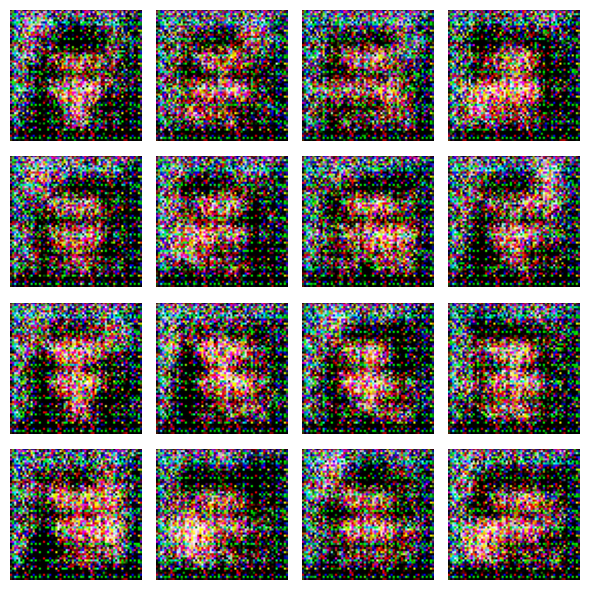

In [15]:
import matplotlib.pyplot as plt

fixed_noise = torch.randn((batch_size, noise_dim, 1, 1), dtype=torch.float32, device=device)
gen_.eval()
with torch.no_grad():
    fake_images = gen_(noise)

# Move fake_images to CPU before plotting
fake_images = fake_images.cpu()  # Add this line

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    # Permute from (C, H, W) to (H, W, C)
    img = fake_images[i].permute(1, 2, 0)
    ax.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)
    ax.axis("off")

plt.tight_layout()
plt.show()